In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import tqdm
import copy
import gc
import sys
import os
import f90nml

import bokeh
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral11

from bokeh.models.mappers import CategoricalColorMapper

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import scipy as sp
from scipy.sparse import linalg

First we import the data from the test simulations

In [67]:
simDataTable=pd.read_csv("Test_Simulation_Milestoning_Data.csv")
simDataTable.head()

,Window,Frame,Time,X,V,F,E
0,0,499,0.499,-4.194121,0.169740,0.131066,0.582288
1,0,999,0.999,-4.275652,-0.031547,0.390135,0.575607
2,0,1499,1.499,-4.167321,-0.190520,0.130229,0.583354
3,0,1999,1.999,-3.959980,-0.298505,0.123749,0.590011
4,0,2499,2.499,-3.670802,-0.304773,-0.677272,0.558500


Now we need to bin the coordinate data.
For this we need to know the window bounds

In [68]:
windowWidth=.5
windowK=10.0
windowCenters=np.arange(-8,9)*windowWidth
winMaxs=windowCenters+windowWidth/2.0
winMins=windowCenters-windowWidth/2.0

For the one dimensional case, assingin bin indices can be easily accomplished by the numpy command 'digitize'

The example below illustartes this.

Note that we need two additional 'bins'.
Bin zero will account for anything to the left of the leftmost window edge and the last bin will capture anything to the right of the rightmost window edge.

We then use didgitize to apply this bin indexing to an array of numbers from -5 to 5 spaced .25 units apart.

In [69]:
xvals=np.arange(-20,21)*.25
print zip(np.arange(len(windowCenters))+1,zip(winMins,winMaxs))
print zip(xvals,np.digitize(xvals,bins=np.concatenate([winMins,[winMaxs[-1]]])))

[(1, (-4.25, -3.75)), (2, (-3.75, -3.25)), (3, (-3.25, -2.75)), (4, (-2.75, -2.25)), (5, (-2.25, -1.75)), (6, (-1.75, -1.25)), (7, (-1.25, -0.75)), (8, (-0.75, -0.25)), (9, (-0.25, 0.25)), (10, (0.25, 0.75)), (11, (0.75, 1.25)), (12, (1.25, 1.75)), (13, (1.75, 2.25)), (14, (2.25, 2.75)), (15, (2.75, 3.25)), (16, (3.25, 3.75)), (17, (3.75, 4.25))]
[(-5.0, 0), (-4.75, 0), (-4.5, 0), (-4.25, 1), (-4.0, 1), (-3.75, 2), (-3.5, 2), (-3.25, 3), (-3.0, 3), (-2.75, 4), (-2.5, 4), (-2.25, 5), (-2.0, 5), (-1.75, 6), (-1.5, 6), (-1.25, 7), (-1.0, 7), (-0.75, 8), (-0.5, 8), (-0.25, 9), (0.0, 9), (0.25, 10), (0.5, 10), (0.75, 11), (1.0, 11), (1.25, 12), (1.5, 12), (1.75, 13), (2.0, 13), (2.25, 14), (2.5, 14), (2.75, 15), (3.0, 15), (3.25, 16), (3.5, 16), (3.75, 17), (4.0, 17), (4.25, 18), (4.5, 18), (4.75, 18), (5.0, 18)]


We can now use the above procedure to bin our X coordinate data for each window.

We can make use of digitize as above. We note that if you give digitize N bin edges, it will give you N+1 bins. Also, by default it assumes the edges are the left hand sides of each bin.

This means:
    1. We want to give nWindows-1 bin edges
    2. We want to give it the window minima (left hand edges)

In [70]:
binEdges=winMins[1:] #np.concatenate([winMins,[winMaxs[-1]]])
digitize_kwds={"bins":binEdges}
simDataTable['X_Index']=simDataTable.X.apply(np.digitize,**digitize_kwds)
simDataTable.head()

,Window,Frame,Time,X,V,F,E,X_Index
0,0,499,0.499,-4.194121,0.169740,0.131066,0.582288,0
1,0,999,0.999,-4.275652,-0.031547,0.390135,0.575607,0
2,0,1499,1.499,-4.167321,-0.190520,0.130229,0.583354,0
3,0,1999,1.999,-3.959980,-0.298505,0.123749,0.590011,0
4,0,2499,2.499,-3.670802,-0.304773,-0.677272,0.558500,1


Before proceeding, it is a good idea to visualize the results.

We can make use of a hand python widget to allow us to easily select a given window to view.

The red line shows the actual observed values of $x$

The orange dots indicate the window bin that x was assigned into for the given frame.

The black horizontal lines indicate the edges of the window bin.

An intersting note is that there are no transitions on the negative side of window 0 and no
positive side of window 16. This essentially means that we count anything to the right of bin 16's right edge as part of bin 16 and anything to the left of bin 0's left edge as part of bin0

In [71]:
@interact
def plot_window(window=(simDataTable.Window.min(),simDataTable.Window.max(),1)):
    plt.figure(figsize=(12,9))
    plt.rcParams['axes.facecolor']='grey'
    nWindows=len(simDataTable.Window.unique())
    plotData=simDataTable[simDataTable.Window==window]
    plt.scatter(plotData.Time,
                (plotData.X_Index-(nWindows-1)/2.)*windowWidth,
                c='orange',#Spectral11[window%11],
                s=4,
                label='Window_%02g'%window)
    plt.plot(plotData.Time,
             plotData.X,
             'r',
             #Spectral11[window%11],
             label='Window_%02g'%window)
    plt.plot(plotData.Time,
             [winMins[window]]*len(plotData),c='k')
    plt.plot(plotData.Time,
             [winMaxs[window]]*len(plotData),c='k')
    plt.legend()
    plt.grid()
    plt.show()

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT04LCBkZXNjcmlwdGlvbj11J3dpbmRvdycsIG1heD0xNiksIE91dHB1dCgpKSwgX2RvbV9jbGFzc2VzPSh1J3dpZGdldC1pbnTigKY=


We are now ready to compute the escape matrix.

This is an Nwindow by Nwindow matrix with a diagonal of 0.
The off diagonals represent the probability of transitioning form one window to another.

I.e.
$$M_{i,j}=N_{i->j}/N_{i}$$
where $M_{i,j}$ is an element of the escape matrix, $N_{i->j}$ is the number of frames where $x$ is observed in bin $j$ when it was in bin $i$ on the previous frame, and $N_{i}$ is the number of frames where $x$ is observed in bin $i$ as computed from the simulation with the milestoning well for bin $i$

--- --- ---
escapeMatrix entry for window 0:
[0.000, 0.177, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
Probability of being inside window (1-M(i,i)+1-M(i,i-1)): 0.823
--- --- ---
escapeMatrix entry for window 1:
[0.201, 0.000, 0.194, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
Ratio of left to right exit frequencies: 0.000
Probability of being inside window (1-M(i,i)+1-M(i,i-1)): 0.604
--- --- ---
escapeMatrix entry for window 2:
[0.000, 0.188, 0.000, 0.180, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
Ratio of left to right exit frequencies: 1.038
Probability of being inside window (1-M(i,i)+1-M(i,i-1)): 0.632
--- --- ---
escapeMatrix entry for window 3:
[0.000, 0.000, 0.177, 0.000, 0.177, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
Ratio of left to right exit frequencies: 1.042
Probabi

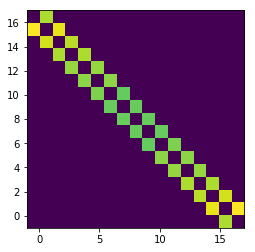

In [72]:
#note that our window indexing starts at 0
#this causes a problem for boolean operations since 0 evaluates to false
#while non-zero evaluates as true.
#moreover, our 'bins' span from -1 to nWindows+1...
#thus we will temporarily add 2 to all window and X_index values
#this way our X_index will span values from 1 to nWindows+2
windows=np.sort(simDataTable.Window.unique())
xbins=np.sort(simDataTable.X_Index.unique())
nBins=len(xbins)
escapeMat=np.zeros((nBins,nBins))
pCenters=np.zeros(len(windows))
escapeRatios=np.zeros(len(windows))
#iVal->escape matrix row index
#xbin->window
#cVal->place holder for bin index with indexing starting at 1
for iVal,xbin in enumerate(xbins):
    if xbin in windows:
        tempDat=simDataTable[simDataTable.Window==xbin]
        cVal=xbin+1
        binVec=np.array(tempDat.X_Index+1)
        binC=(binVec==cVal)
        binT=(1-binC[1:])*binC[:-1]*binVec[1:]
        tCounts=np.unique(binT,return_counts=True)
        transInds=tCounts[0][1:] #first entry should always be for binT==0
        transCounts=tCounts[1][1:]
        cCount=np.sum(binC)
        for iInd,Ind in enumerate(transInds):
            escapeMat[iVal,Ind-1]=1.*transCounts[iInd]/cCount
        print "--- --- ---"
        print "escapeMatrix entry for window %g:"%xbin
        print '['+', '.join(map(lambda x: '%.3f'%x,escapeMat[iVal,:]))+']'
        if (iVal > 0) & (iVal < (len(windows)-1)):
            escapeRatios[iVal]=1.*escapeMat[iVal,iVal-1]/escapeMat[iVal,iVal+1]
            print 'Ratio of left to right exit frequencies: %.3f'%(
                escapeRatios[iVal-1])
        pCenters[iVal]=1.0-np.sum(escapeMat[iVal,:])
        print "Probability of being inside window (1-M(i,i)+1-M(i,i-1)): %.3f"%(
            pCenters[iVal])
print "--- --- ---"

plt.imshow(escapeMat,extent=(-1,nBins,-1,nBins))
plt.show()

We can use the definition of the escape matrix to help us find the equilibrium distribution.

The procedure is an adaptation of matlab code from our colaborator. The essential theory is that at equilibrium, the net flux into a given state should equal the net flux out.

Our escape matrix was originally defined in terms of the cells of an N-dimensional voronoi tesselation we use the term 'cell' in the following discussion instead of 'window' but for a 1D case the two are interchangeable. defines the net flux $\matrix{E}_{i,j}$ defines the flux from cell (window) $i$ into cell $j$.
Or another way to think of it is the probability that a particle sitting in cell $i$ will move into cell $j$ is given by $\matrix{E}_{i,j}$.
By this definition, the transpose of $\matrix{E}$ would give the probability of moving INTO cell $i$ from cell $j$. If we then subtract the off diagonal elements from 1 (i.e. $1-\sum\limits_{j}{\matrix{E}^{T}_{i,j}}$)
you would have the total probability that a particle enters cell $i$ from an adjacent cell.

So we may construct a transition matrix as:

$$\matrix{A}_{i,j}=\begin{cases} 
      \matrix{E}_{i,j} & i \neq j \\ 
      1-\sum\limits_{k}{\matrix{E}^{T}_{i,k}} & i = j
   \end{cases}$$

We then seek an equilibrium distribtuion $\bar{\pi}$ such that $\matrix{A}\bar{\pi}=\bar{\pi}$ where $\pi_i$ is the equilibrium probability of being in cell $i$ (and thus $\sum\limits_{i}{\pi_i}=1$).

This translates to the problem of finding an eigenvector ($\bar{\pi}$) of $\matrix{A}$ for which the corresponding eigenvalue is 1. In the case of a proper transition matrix this should be the dominant eigenvector.

Once we have the equilibrium distribution $\bar{\pi}$, we then calculate the pmf as $G_i=-k_bT\ln{\pi_i}$

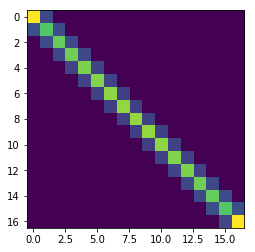

Eigenvalues: [1.         0.99419861 0.97719367 0.95005688 0.91168734 0.86486435
 0.81172374 0.7518095  0.69130314 0.62691286 0.56111501 0.50542215
 0.4506442  0.40128091 0.38131335 0.31357887 0.31306616]


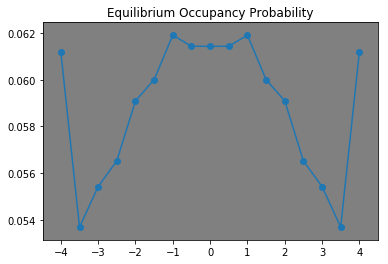

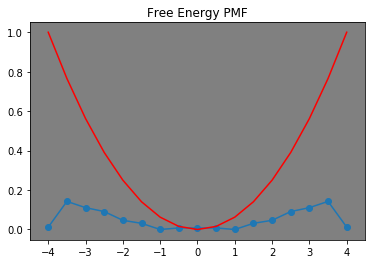

equilibrium probabilities : [0.0611815  0.05369271 0.0554237  0.05652891 0.05909841 0.06000761
 0.06191262 0.06143637 0.06143637 0.06143637 0.06191262 0.06000761
 0.05909841 0.05652891 0.0554237  0.05369271 0.0611815 ]
free energies (kcal/mol*K): [2.7939104  2.92447806 2.89274802 2.87300309 2.82855132 2.81328385
 2.78203131 2.78975335 2.78975335 2.78975335 2.78203131 2.81328385
 2.82855132 2.87300309 2.89274802 2.92447806 2.7939104 ]


In [74]:
#kbT=0.0019872041*300 #kcal/mol
kbT=1
Rmat=np.matrix(escapeMat)
Dmat=np.matrix(np.diag(1-np.sum(escapeMat,axis=1)))
Pvec=pCenters #use this as a starting guess
Pvec=Pvec/np.sum(Pvec)

RDmat=Rmat+Dmat
plt.imshow(RDmat)
plt.show()

outEig=np.linalg.eig(RDmat.T)
si=np.argsort(1-outEig[0])
print 'Eigenvalues:',
print outEig[0][si]
outVec=np.array(outEig[1])[:,si[0]]
outVec=outVec/np.sum(outVec)
plt.plot(windowCenters,outVec)
plt.scatter(windowCenters,outVec)
plt.title("Equilibrium Occupancy Probability")
plt.show()
plt.plot(windowCenters,-kbT*np.log(outVec)-np.min(-kbT*np.log(outVec)))
plt.scatter(windowCenters,-kbT*np.log(outVec)-np.min(-kbT*np.log(outVec)))
potFun=lambda x: (x/4.0)**2
plt.plot(windowCenters,potFun(windowCenters),'r',label='actual potential')
plt.title("Free Energy PMF")
plt.show()
print "equilibrium probabilities :",
print outVec
print "free energies (kT):",
print -kbT*np.log(outVec)

Qualitatively, the results give us what we expect, although the probability range and free energy is quite off. Nevertheless we see a minimal probability at the well center and maxima at the edges.

Next, lets see what we get from the langevin dynamics version.

# Langevin Dynamics Results

In [54]:
simDataTable=pd.read_csv("Test_Simulation_Milestoning_Data.lvd.csv")
simDataTable.head()

,Window,Frame,Time,X,V,F,E
0,0,499,0.499,-4.248000,0.446072,0.531000,0.801735
1,0,999,0.999,-4.023418,0.896501,0.502927,1.318039
2,0,1499,1.499,-3.616782,-1.602452,-19.530557,5.003405
3,0,1999,1.999,-3.721527,1.980668,-3.805804,4.836817
4,0,2499,2.499,-4.359730,-1.311016,17.004509,3.296854


Now we need to bin the coordinate data.
For this we need to know the window bounds

In [55]:
windowWidth=.5
windowK=150.0
windowCenters=np.arange(-8,9)*windowWidth
winMaxs=windowCenters+windowWidth/2.0
winMins=windowCenters-windowWidth/2.0

For the one dimensional case, assingin bin indices can be easily accomplished by the numpy command 'digitize'

The example below illustartes this.

Note that we need two additional 'bins'.
Bin zero will account for anything to the left of the leftmost window edge and the last bin will capture anything to the right of the rightmost window edge.

We then use didgitize to apply this bin indexing to an array of numbers from -5 to 5 spaced .25 units apart.

In [56]:
xvals=np.arange(-20,21)*.25
print zip(np.arange(len(windowCenters))+1,zip(winMins,winMaxs))
print zip(xvals,np.digitize(xvals,bins=np.concatenate([winMins,[winMaxs[-1]]])))

[(1, (-4.25, -3.75)), (2, (-3.75, -3.25)), (3, (-3.25, -2.75)), (4, (-2.75, -2.25)), (5, (-2.25, -1.75)), (6, (-1.75, -1.25)), (7, (-1.25, -0.75)), (8, (-0.75, -0.25)), (9, (-0.25, 0.25)), (10, (0.25, 0.75)), (11, (0.75, 1.25)), (12, (1.25, 1.75)), (13, (1.75, 2.25)), (14, (2.25, 2.75)), (15, (2.75, 3.25)), (16, (3.25, 3.75)), (17, (3.75, 4.25))]
[(-5.0, 0), (-4.75, 0), (-4.5, 0), (-4.25, 1), (-4.0, 1), (-3.75, 2), (-3.5, 2), (-3.25, 3), (-3.0, 3), (-2.75, 4), (-2.5, 4), (-2.25, 5), (-2.0, 5), (-1.75, 6), (-1.5, 6), (-1.25, 7), (-1.0, 7), (-0.75, 8), (-0.5, 8), (-0.25, 9), (0.0, 9), (0.25, 10), (0.5, 10), (0.75, 11), (1.0, 11), (1.25, 12), (1.5, 12), (1.75, 13), (2.0, 13), (2.25, 14), (2.5, 14), (2.75, 15), (3.0, 15), (3.25, 16), (3.5, 16), (3.75, 17), (4.0, 17), (4.25, 18), (4.5, 18), (4.75, 18), (5.0, 18)]


We can now use the above procedure to bin our X coordinate data for each window.

We can make use of digitize as above. We note that if you give digitize N bin edges, it will give you N+1 bins. Also, by default it assumes the edges are the left hand sides of each bin.

This means:
    1. We want to give nWindows-1 bin edges
    2. We want to give it the window minima (left hand edges)

In [57]:
binEdges=winMins[1:] #np.concatenate([winMins,[winMaxs[-1]]])
digitize_kwds={"bins":binEdges}
simDataTable['X_Index']=simDataTable.X.apply(np.digitize,**digitize_kwds)
simDataTable.head()

,Window,Frame,Time,X,V,F,E,X_Index
0,0,499,0.499,-4.248000,0.446072,0.531000,0.801735,0
1,0,999,0.999,-4.023418,0.896501,0.502927,1.318039,0
2,0,1499,1.499,-3.616782,-1.602452,-19.530557,5.003405,1
3,0,1999,1.999,-3.721527,1.980668,-3.805804,4.836817,1
4,0,2499,2.499,-4.359730,-1.311016,17.004509,3.296854,0


Before proceeding, it is a good idea to visualize the results.

We can make use of a hand python widget to allow us to easily select a given window to view.

The red line shows the actual observed values of $x$

The orange dots indicate the window bin that x was assigned into for the given frame.

The black horizontal lines indicate the edges of the window bin.

An intersting note is that there are no transitions on the negative side of window 0 and no
positive side of window 16. This essentially means that we count anything to the right of bin 16's right edge as part of bin 16 and anything to the left of bin 0's left edge as part of bin0

In [58]:
@interact
def plot_window(window=(simDataTable.Window.min(),simDataTable.Window.max(),1)):
    plt.figure(figsize=(12,9))
    plt.rcParams['axes.facecolor']='grey'
    nWindows=len(simDataTable.Window.unique())
    plotData=simDataTable[simDataTable.Window==window]
    plt.scatter(plotData.Time,
                (plotData.X_Index-(nWindows-1)/2.)*windowWidth,
                c='orange',#Spectral11[window%11],
                s=4,
                label='Window_%02g'%window)
    plt.plot(plotData.Time,
             plotData.X,
             'r',
             #Spectral11[window%11],
             label='Window_%02g'%window)
    plt.plot(plotData.Time,
             [winMins[window]]*len(plotData),c='k')
    plt.plot(plotData.Time,
             [winMaxs[window]]*len(plotData),c='k')
    plt.legend()
    plt.grid()
    plt.show()

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT04LCBkZXNjcmlwdGlvbj11J3dpbmRvdycsIG1heD0xNiksIE91dHB1dCgpKSwgX2RvbV9jbGFzc2VzPSh1J3dpZGdldC1pbnTigKY=


We are now ready to compute the escape matrix.

This is an Nwindow by Nwindow matrix with a diagonal of 0.
The off diagonals represent the probability of transitioning form one window to another.

I.e.
$$M_{i,j}=N_{i->j}/N_{i}$$
where $M_{i,j}$ is an element of the escape matrix, $N_{i->j}$ is the number of frames where $x$ is observed in bin $j$ when it was in bin $i$ on the previous frame, and $N_{i}$ is the number of frames where $x$ is observed in bin $i$ as computed from the simulation with the milestoning well for bin $i$

--- --- ---
escapeMatrix entry for window 0:
[0.000, 0.228, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
Probability of being inside window (1-M(i,i)+1-M(i,i-1)): 0.772
--- --- ---
escapeMatrix entry for window 1:
[0.158, 0.000, 0.233, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
Ratio of left to right exit frequencies: 0.000
Probability of being inside window (1-M(i,i)+1-M(i,i-1)): 0.608
--- --- ---
escapeMatrix entry for window 2:
[0.000, 0.100, 0.000, 0.238, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
Ratio of left to right exit frequencies: 0.679
Probability of being inside window (1-M(i,i)+1-M(i,i-1)): 0.662
--- --- ---
escapeMatrix entry for window 3:
[0.000, 0.000, 0.172, 0.000, 0.180, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
Ratio of left to right exit frequencies: 0.419
Probabi

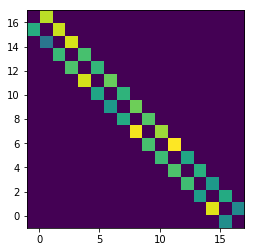

In [59]:
#note that our window indexing starts at 0
#this causes a problem for boolean operations since 0 evaluates to false
#while non-zero evaluates as true.
#moreover, our 'bins' span from -1 to nWindows+1...
#thus we will temporarily add 2 to all window and X_index values
#this way our X_index will span values from 1 to nWindows+2
windows=np.sort(simDataTable.Window.unique())
xbins=np.sort(simDataTable.X_Index.unique())
nBins=len(xbins)
escapeMat=np.zeros((nBins,nBins))
pCenters=np.zeros(len(windows))
escapeRatios=np.zeros(len(windows))
#iVal->escape matrix row index
#xbin->window
#cVal->place holder for bin index with indexing starting at 1
for iVal,xbin in enumerate(xbins):
    if xbin in windows:
        tempDat=simDataTable[simDataTable.Window==xbin]
        cVal=xbin+1
        binVec=np.array(tempDat.X_Index+1)
        binC=(binVec==cVal)
        binT=(1-binC[1:])*binC[:-1]*binVec[1:]
        tCounts=np.unique(binT,return_counts=True)
        transInds=tCounts[0][1:] #first entry should always be for binT==0
        transCounts=tCounts[1][1:]
        cCount=np.sum(binC)
        for iInd,Ind in enumerate(transInds):
            escapeMat[iVal,Ind-1]=1.*transCounts[iInd]/cCount
        print "--- --- ---"
        print "escapeMatrix entry for window %g:"%xbin
        print '['+', '.join(map(lambda x: '%.3f'%x,escapeMat[iVal,:]))+']'
        if (iVal > 0) & (iVal < (len(windows)-1)):
            escapeRatios[iVal]=1.*escapeMat[iVal,iVal-1]/escapeMat[iVal,iVal+1]
            print 'Ratio of left to right exit frequencies: %.3f'%(
                escapeRatios[iVal-1])
        pCenters[iVal]=1.0-np.sum(escapeMat[iVal,:])
        print "Probability of being inside window (1-M(i,i)+1-M(i,i-1)): %.3f"%(
            pCenters[iVal])
print "--- --- ---"

plt.imshow(escapeMat,extent=(-1,nBins,-1,nBins))
plt.show()

In [42]:
#make sure that there are no milestones where x enters a window that is
#not directly adjacent to the milestone center
print np.sum(np.abs(escapeMat)>0,axis=1)
print np.sum(np.abs(escapeMat)>0,axis=1)>2
np.sum(np.sum(np.abs(escapeMat)>0,axis=1)>2)

[1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1]
[False False False False False False False False False False False False
 False False False False False]


0

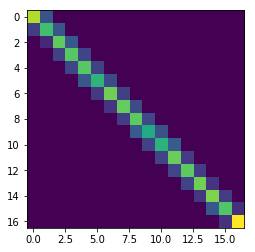

Eigenvalues: [1.         0.99152131 0.97078592 0.93770417 0.90368243 0.86258899
 0.81827195 0.74867035 0.70057287 0.60233953 0.53136383 0.48923744
 0.4290605  0.38616787 0.36728506 0.28744872 0.22494375]


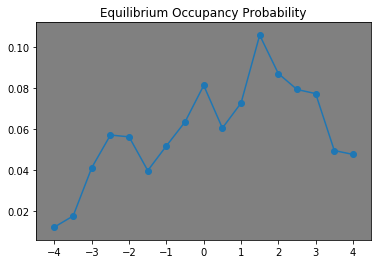

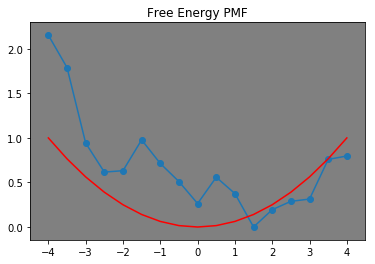

equilibrium probabilities : [0.01226769 0.01765371 0.04119198 0.05706522 0.05616871 0.03975299
 0.05179237 0.06347503 0.08123293 0.06045241 0.07263449 0.10570429
 0.0870033  0.07924485 0.07723732 0.04949575 0.04762696]
free energies (kcal/mol*K): [4.40078626 4.03680959 3.18951173 2.86356037 2.87939547 3.22507023
 2.96051253 2.75710861 2.51043457 2.80589878 2.62231539 2.24710978
 2.44180921 2.53521281 2.56087256 3.00586851 3.04435635]


In [66]:
#kbT=0.0019872041*300 #kcal/mol
kbT=1
Rmat=np.matrix(escapeMat)
Dmat=np.matrix(np.diag(1-np.sum(escapeMat,axis=1)))
Pvec=pCenters #use this as a starting guess
Pvec=Pvec/np.sum(Pvec)

RDmat=Rmat+Dmat
plt.imshow(RDmat)
plt.show()

outEig=np.linalg.eig(RDmat.T)
si=np.argsort(1-outEig[0])
print 'Eigenvalues:',
print outEig[0][si]
outVec=np.array(outEig[1])[:,si[0]]
outVec=outVec/np.sum(outVec)
plt.plot(windowCenters,outVec)
plt.scatter(windowCenters,outVec)
plt.title("Equilibrium Occupancy Probability")
plt.show()
plt.plot(windowCenters,-kbT*np.log(outVec)-np.min(-kbT*np.log(outVec)))
plt.scatter(windowCenters,-kbT*np.log(outVec)-np.min(-kbT*np.log(outVec)))

potFun=lambda x: (x/4.0)**2
plt.plot(windowCenters,potFun(windowCenters),'r',label='actual potential')
plt.title("Free Energy PMF")
plt.show()
print "equilibrium probabilities :",
print outVec
print "free energies (kT):",
print -kbT*np.log(outVec)

# MD channel permeation example

Next lets see how this works using data collected from milestoning simulations for permation of a channel my a small organic ligand.


In [76]:
dataDir='test_md_data'
dataFiles=np.sort(os.listdir(dataDir))
dataFiles

array(['window_00.rest', 'window_00_rest.dat', 'window_01.rest',
       'window_01_rest.dat', 'window_02.rest', 'window_02_rest.dat',
       'window_03.rest', 'window_03_rest.dat'], dtype='|S18')

the data files are listed in the directory 'test_md_data'
the files ending in '.dat' contain the output from the milestoning restraints
while the '.rest' files contain the restraint input parameters.
lets inspect the first output file

In [77]:
#The column names are not given in the data file so we need to define them ourselves
#the data file will contain some dummy columns which are present to make it more human readable
#we will label them accordingly so they can be easily removed later
#For current purposes, we only need the Z coordinates for the waters-ligand restraints and the
#frame numbers.
datColNames=np.concatenate([
     ['Frame'],
     ['MG%g'%iiMG for iiMG in np.arange(6)],
     ['DUMMYC_X','C_X','DUMMYC_Y','C_Y','DUMMYC_Z','C_Z','R1'],
     ['DUMMYW1L_X','W1L_X','DUMMYW1L_Y','W1L_Y','DUMMYW1L_Z','W1L_Z','W1L_R'],
     ['DUMMYW2L_X','W2L_X','DUMMYW2L_Y','W2L_Y','DUMMYW2L_Z','W2L_Z','W2L_R'],
    ])
pd.read_csv(dataDir+'/'+dataFiles[1],delim_whitespace=True,
            names=datColNames).head()

,Frame,MG0,MG1,MG2,MG3,MG4,MG5,DUMMYC_X,C_X,DUMMYC_Y,...,DUMMYW1L_Z,W1L_Z,W1L_R,DUMMYW2L_X,W2L_X,DUMMYW2L_Y,W2L_Y,DUMMYW2L_Z,W2L_Z,W2L_R
0,0,1.959,1.873,1.940,1.902,2.015,1.946,x:,-13.329,y:,...,z:,110.140,112.844,x:,10.766,y:,26.174,z:,-15.195,32.123
1,500,1.958,1.946,1.963,1.899,1.988,1.888,x:,-13.094,y:,...,z:,110.548,113.265,x:,10.342,y:,26.464,z:,-14.744,32.010
2,1000,1.935,2.071,1.951,1.895,1.986,1.950,x:,-13.316,y:,...,z:,110.709,113.389,x:,10.483,y:,26.262,z:,-14.688,31.864
3,1500,1.969,1.922,1.990,1.912,1.984,1.942,x:,-12.631,y:,...,z:,110.696,113.418,x:,10.123,y:,26.661,z:,-14.631,32.052
4,2000,1.883,1.915,1.894,1.895,2.094,1.984,x:,-12.681,y:,...,z:,111.143,113.829,x:,10.083,y:,26.527,z:,-14.230,31.746


we also need to get information about the milestoning restraint parameters.
This is contained in the corresponding '.rest' file for each window.
These files are in Fortran namelist format. We can use the f90nml package to load them here.

In [78]:
f90nml.read(dataDir+'/'+dataFiles[0])

Namelist([('rst',
           [Namelist([('iat', [-1, -1]),
                      ('r1', 95.0),
                      ('r2', 109.0),
                      ('r3', 111.0),
                      ('r4', 135.0),
                      ('rk2', 0.0),
                      ('rk3', 0.0),
                      ('iresid', 0),
                      ('fxyz', [0, 0, 1]),
                      ('outxyz', 1),
                      ('igr1', 102701),
                      ('igr2', 22402)]),
            Namelist([('iat', [-1, -1]),
                      ('r1', 5.0),
                      ('r2', 14.0),
                      ('r3', 16.0),
                      ('r4', 40.0),
                      ('rk2', 100.0),
                      ('rk3', 100.0),
                      ('iresid', 0),
                      ('fxyz', [0, 0, 1]),
                      ('outxyz', 1),
                      ('igr1', 136412),
                      ('igr2', 22402)])])])

The two 'Namelist' sub entries correspond to the two restraints use to define a milstoning window. The main entry is 'rst' which would let the AMBER md engine know that these are standard nmr style restraints.

These correspond to distance restraints limited to z-axis only between one of a pair of two water molecules and the ligand molecule.
During the simulation, the water molecules themselves are restrained to their original cartesian coordinates.

A pair of molecules was used due to technical considerations regarding the system size and periodic boundary set up which will not be elaborated on here. Essentially the distance between the water molecules, is roughly constant as well as the distance between either molecule and the channel.
This allows us to use the distance between either molecule and the ligand as a proxy for the z-coordinate of the ligand w.r.t. the channel center.

The values 'r1', 'r2', 'r3', and 'r4' define control points on a flat-bottom harmonic restraint.
r2 and r3 define the flat bottom region while r1-r2 and r3-r4 define the left and right side parabololic potential regions. The values of rk2 and rk3 define the force constant for these harmonic regions.

Note that only one of the two water molecule retraints is 'turned on' at a given time (as can be seen by looking at rk2 and rk3)

So, for each window we have to locate which restraint was used and extract the restraint information for that window.

More importantly, however, we note taht at the center two windows the water molecule being used switches. This means that we need to
    1. Define a generalized coordinate that relates the two ligand distances to the channel distance
    2. Ensure that there is a good correlation between the distance from each ligand
    3. Ensure that the distance between water molecules does not fluctuate to strongly relative to the milestone window width
    
Lets first load the output data and restraint parameter data into a joint data frame. We can discard the X and Y columns of the data since they are irrelevant for our purposes.

In [79]:
zCoordFiles=[dataFile for dataFile in dataFiles if '.dat' in dataFile]
restFiles=[restFile for restFile in dataFiles if '.rest' in restFile]
mdDataTables=[]
parmValNames=['r1','r2','r3','r4','rk2','rk3','igr1','igr2']
parmData={}
parmData['Window']=[]
datColNames=np.concatenate([
     ['Timestep'],
     ['MG%g'%iiMG for iiMG in np.arange(6)],
     ['DUMMYC_X','C_X','DUMMYC_Y','C_Y','DUMMYC_Z','C_Z','R1'],
     ['DUMMYW1L_X','W1L_X','DUMMYW1L_Y','W1L_Y','DUMMYW1L_Z','W1L_Z','W1L_R'],
     ['DUMMYW2L_X','W2L_X','DUMMYW2L_Y','W2L_Y','DUMMYW2L_Z','W2L_Z','W2L_R'],
    ])
for valName in parmValNames:
    parmData['W1L_'+valName]=[]
    parmData['W2L_'+valName]=[]
for iWin,winFileName in enumerate(zCoordFiles):
    print 'Loading data for %s'%(
        winFileName.split('.')[0])
    windowID=winFileName.split('.')[0].split('_')[1]
    restFileName=restFiles[iWin]
    tempTable=pd.read_csv(dataDir+'/'+winFileName,delim_whitespace=True,
                          names=datColNames)
    #tempTable=tempTable.drop(columns=[colName for colName in tempTable.columns \
    #                        if ('x' in colName) | ('y' in colName) | \
    #                           ('X' in colName) | ('Y' in colName)])
    tempNMLfile=f90nml.read(dataDir+'/'+restFileName)
    tempTable['Window']=np.int(windowID)
    tempTable=tempTable[['Window','Timestep','W1L_Z','W2L_Z']]
    tempVals=np.zeros(len(parmValNames)+1)
    
    parmData['Window'].append(np.int(windowID))
    for valName in parmValNames:
        tempTable['W1L_'+valName]=tempNMLfile['rst'][0][valName]
        parmData['W1L_'+valName].append(tempNMLfile['rst'][0][valName])
        tempTable['W2L_'+valName]=tempNMLfile['rst'][1][valName]
        parmData['W2L_'+valName].append(tempNMLfile['rst'][1][valName])
        
    mdDataTables.append(pd.DataFrame.copy(tempTable))
    gc.collect()
mdTable=pd.concat(mdDataTables)
mdTable=mdTable[np.concatenate([
    ['Window','Timestep'],
    [colName for colName in mdTable.columns if 'W1' in colName],
    [colName for colName in mdTable.columns if 'W2' in colName]
])]
parmData=pd.DataFrame(parmData)
parmData

Loading data for window_00_rest
Loading data for window_01_rest
Loading data for window_02_rest
Loading data for window_03_rest


,W1L_igr1,W1L_igr2,W1L_r1,W1L_r2,W1L_r3,W1L_r4,W1L_rk2,W1L_rk3,W2L_igr1,W2L_igr2,W2L_r1,W2L_r2,W2L_r3,W2L_r4,W2L_rk2,W2L_rk3,Window
0,102701,22402,95.0,109.0,111.0,135.0,0.0,0.0,136412,22402,5.0,14.0,16.0,40.0,100.0,100.0,0
1,102701,22402,95.0,107.0,109.0,135.0,0.0,0.0,136412,22402,5.0,16.0,18.0,40.0,100.0,100.0,1
2,102701,22402,95.0,105.0,107.0,135.0,0.0,0.0,136412,22402,5.0,18.0,20.0,40.0,100.0,100.0,2
3,102701,22402,95.0,103.0,105.0,135.0,0.0,0.0,136412,22402,5.0,20.0,22.0,40.0,100.0,100.0,3


In [80]:
mdTable.head()

,Window,Timestep,W1L_Z,W1L_r1,W1L_r2,W1L_r3,W1L_r4,W1L_rk2,W1L_rk3,W1L_igr1,W1L_igr2,W2L_Z,W2L_r1,W2L_r2,W2L_r3,W2L_r4,W2L_rk2,W2L_rk3,W2L_igr1,W2L_igr2
0,0,0,110.140,95.0,109.0,111.0,135.0,0.0,0.0,102701,22402,-15.195,5.0,14.0,16.0,40.0,100.0,100.0,136412,22402
1,0,500,110.548,95.0,109.0,111.0,135.0,0.0,0.0,102701,22402,-14.744,5.0,14.0,16.0,40.0,100.0,100.0,136412,22402
2,0,1000,110.709,95.0,109.0,111.0,135.0,0.0,0.0,102701,22402,-14.688,5.0,14.0,16.0,40.0,100.0,100.0,136412,22402
3,0,1500,110.696,95.0,109.0,111.0,135.0,0.0,0.0,102701,22402,-14.631,5.0,14.0,16.0,40.0,100.0,100.0,136412,22402
4,0,2000,111.143,95.0,109.0,111.0,135.0,0.0,0.0,102701,22402,-14.230,5.0,14.0,16.0,40.0,100.0,100.0,136412,22402


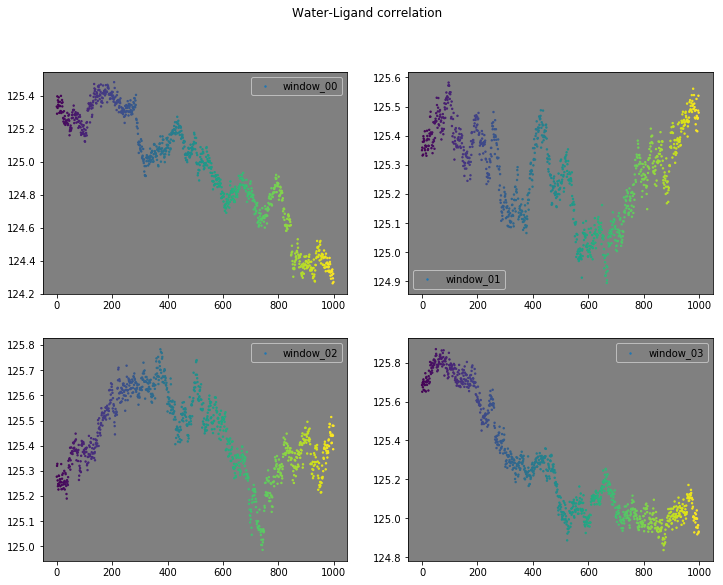

In [81]:
nWindows=len(mdTable.Window.unique())
fig,axs=plt.subplots(int(np.ceil(np.sqrt(nWindows*1.))),
                     int(np.ceil(1.*nWindows/np.ceil(np.sqrt(nWindows)))))
fig.set_figwidth(12)
fig.set_figheight(9)

for iWin,window in enumerate(mdTable.Window.unique()):
    ax=axs.flat[iWin]
    plotData=mdTable[mdTable.Window==window]
    ax.scatter(plotData.Timestep*.002,np.abs(plotData.W2L_Z)+np.abs(plotData.W1L_Z),
               c=plotData.Timestep,
                label='window_%02g'%window,s=2)
    ax.legend()
    #ax.set_ylim(ymin,ymax)
fig.suptitle('Water-Ligand correlation')
plt.show()

It looks like there is a fair amount of change in water-water distance, and the plots of the correlation between distance from W1 to ligand vs W2 to ligand appear to be bandlike with widths around 0.5 Å.

The width of our windows (see parmData table subset below) is roughly two angstroms, so this may indicate a fair amount of noise in our plots, but at least it is under half the window width

Fortunately, for now only one water molecule was used for restraints so we don't need to worry about the ligand-water distance correlation for the two ligands yet, however, the change in water-water distance indicates that the two water molecules are getting closer together, in spite of relatively strong cartesian restraints.
This is somewhat worrysome since it means that the distance from the water to the channel is likely being decreased as well.

For now, lets forage forward and construct the window information we will need.

In [82]:
parmData[np.concatenate([['Window'],[colName for colName in parmData.columns \
                      if np.sum([(binCol in colName) for binCol in ['_r2','_r3']])]])]

,Window,W1L_r2,W1L_r3,W2L_r2,W2L_r3
0,0,109.0,111.0,14.0,16.0
1,1,107.0,109.0,16.0,18.0
2,2,105.0,107.0,18.0,20.0
3,3,103.0,105.0,20.0,22.0


In [83]:
windowCenters=(parmData.W2L_r2+parmData.W2L_r3)/2.
winMins=parmData.W2L_r2
winMaxs=parmData.W2L_r3
windowWidth=np.mean(winMaxs-winMins)

print 'Window Geometry Summary'
print 'centers:    '+', '.join(windowCenters.map(lambda x: '%.3f'%x))
print 'left edge:  '+', '.join(winMins.map(lambda x: '%.3f'%x))
print 'right edge: '+', '.join(winMaxs.map(lambda x: '%.3f'%x))

Window Geometry Summary
centers:    15.000, 17.000, 19.000, 21.000
left edge:  14.000, 16.000, 18.000, 20.000
right edge: 16.000, 18.000, 20.000, 22.000


We can now extract the data we need from our table into the form needed for our binning as above
then bin and extract the escape matrix.

In [84]:
dt=.002 #simulation timestep (2 fs)
simData=mdTable[['Window']].copy()
simData['Frame']=mdTable.Timestep
simData['Time']=simData.Frame*dt #in ps
simData['X']=mdTable.W2L_Z.abs()
simData.head()

,Window,Frame,Time,X
0,0,0,0.0,15.195
1,0,500,1.0,14.744
2,0,1000,2.0,14.688
3,0,1500,3.0,14.631
4,0,2000,4.0,14.230


In [85]:
binEdges=winMins[1:] #np.concatenate([winMins,[winMaxs[-1]]])
digitize_kwds={"bins":binEdges}
simData['X_Index']=simData.X.apply(np.digitize,**digitize_kwds)
simData.head()

,Window,Frame,Time,X,X_Index
0,0,0,0.0,15.195,0
1,0,500,1.0,14.744,0
2,0,1000,2.0,14.688,0
3,0,1500,3.0,14.631,0
4,0,2000,4.0,14.230,0


In [86]:
@interact
def plot_window(window=(simData.Window.min(),simData.Window.max(),1)):
    plt.figure(figsize=(12,9))
    plt.rcParams['axes.facecolor']='grey'
    nWindows=len(simData.Window.unique())
    plotData=simData[simData.Window==window]
    plt.scatter(plotData.Time,
                (plotData.X_Index+.5)*windowWidth+winMins[0],
                c='orange',#Spectral11[window%11],
                s=4,
                label='Window_%02g'%window)
    plt.plot(plotData.Time,
             plotData.X,
             'r',
             #Spectral11[window%11],
             label='Window_%02g'%window)
    plt.plot(plotData.Time,
             [winMins[window]]*len(plotData),c='k')
    plt.plot(plotData.Time,
             [winMaxs[window]]*len(plotData),c='k')
    plt.legend()
    plt.grid()
    plt.show()

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xLCBkZXNjcmlwdGlvbj11J3dpbmRvdycsIG1heD0zKSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXM9KHUnd2lkZ2V0LWludGXigKY=


--- --- ---
escapeMatrix entry for window 0:
[0.00000, 0.05431, 0.00000, 0.00000]
Probability of being inside window (1-M(i,i)+1-M(i,i-1)): 0.946
--- --- ---
escapeMatrix entry for window 1:
[0.02888, 0.00000, 0.03209, 0.00000]
Ratio of left to right exit frequencies: 0.000
Probability of being inside window (1-M(i,i)+1-M(i,i-1)): 0.939
--- --- ---
escapeMatrix entry for window 2:
[0.00000, 0.01925, 0.00000, 0.04492]
Ratio of left to right exit frequencies: 0.900
Probability of being inside window (1-M(i,i)+1-M(i,i-1)): 0.936
--- --- ---
escapeMatrix entry for window 3:
[0.00000, 0.00000, 0.01114, 0.00000]
Probability of being inside window (1-M(i,i)+1-M(i,i-1)): 0.989
--- --- ---


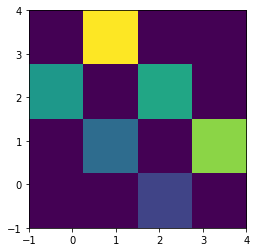

In [87]:
#note that our window indexing starts at 0
#this causes a problem for boolean operations since 0 evaluates to false
#while non-zero evaluates as true.
#moreover, our 'bins' span from -1 to nWindows+1...
#thus we will temporarily add 2 to all window and X_index values
#this way our X_index will span values from 1 to nWindows+2
windows=np.sort(simData.Window.unique())
xbins=np.sort(simData.X_Index.unique())
nBins=len(xbins)
escapeMat=np.zeros((nBins,nBins))
pCenters=np.zeros(len(windows))
escapeRatios=np.zeros(len(windows))
#iVal->escape matrix row index
#xbin->window
#cVal->place holder for bin index with indexing starting at 1
for iVal,xbin in enumerate(xbins):
    if xbin in windows:
        tempDat=simData[simData.Window==xbin]
        cVal=xbin+1
        binVec=np.array(tempDat.X_Index+1)
        binC=(binVec==cVal)
        binT=(1-binC[1:])*binC[:-1]*binVec[1:]
        tCounts=np.unique(binT,return_counts=True)
        transInds=tCounts[0][1:] #first entry should always be for binT==0
        transCounts=tCounts[1][1:]
        cCount=np.sum(binC)
        for iInd,Ind in enumerate(transInds):
            escapeMat[iVal,Ind-1]=1.*transCounts[iInd]/cCount
        print "--- --- ---"
        print "escapeMatrix entry for window %g:"%xbin
        print '['+', '.join(map(lambda x: '%.5f'%x,escapeMat[iVal,:]))+']'
        if (iVal > 0) & (iVal < (len(windows)-1)):
            escapeRatios[iVal]=1.*escapeMat[iVal,iVal-1]/escapeMat[iVal,iVal+1]
            print 'Ratio of left to right exit frequencies: %.3f'%(
                escapeRatios[iVal-1])
        pCenters[iVal]=1.0-np.sum(escapeMat[iVal,:])
        print "Probability of being inside window (1-M(i,i)+1-M(i,i-1)): %.3f"%(
            pCenters[iVal])
print "--- --- ---"

plt.imshow(escapeMat,extent=(-1,nBins,-1,nBins))
plt.show()

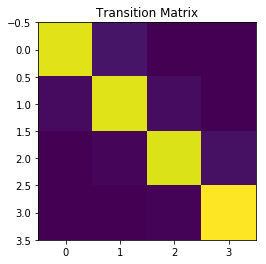

Eigenvalues: [1.         0.98402128 0.93246419 0.89292286]


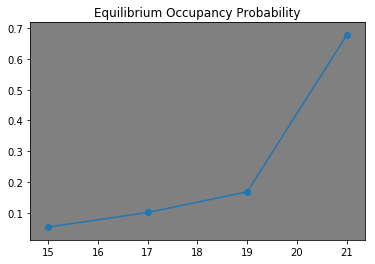

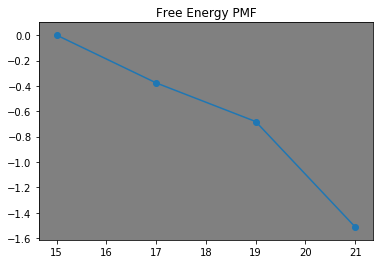

equilibrium probabilities : [0.05361863 0.1008482  0.16808034 0.67745283]
free energies (kcal/mol*K): [ 0.         -0.37660686 -0.6811413  -1.51212916]


In [89]:
kbT=0.0019872041*300 #kcal/mol
Rmat=np.matrix(escapeMat)
Dmat=np.matrix(np.diag(1-np.sum(escapeMat,axis=1)))
Pvec=pCenters #use this as a starting guess
Pvec=Pvec/np.sum(Pvec)

RDmat=Rmat+Dmat
plt.imshow(RDmat)
plt.title("Transition Matrix")
plt.show()

outEig=np.linalg.eig(RDmat.T)
si=np.argsort(1-outEig[0])
print 'Eigenvalues:',
print outEig[0][si]
outVec=np.array(outEig[1])[:,si[0]]
outVec=outVec/np.sum(outVec)
plt.plot(windowCenters,outVec)
plt.scatter(windowCenters,outVec)
plt.title("Equilibrium Occupancy Probability")
plt.show()
plt.plot(windowCenters,-kbT*np.log(outVec)-np.max(-kbT*np.log(outVec)))
plt.scatter(windowCenters,-kbT*np.log(outVec)-np.max(-kbT*np.log(outVec)))
plt.title("Free Energy PMF")
plt.show()
print "equilibrium probabilities :",
print outVec
print "free energies (kcal/mol*K):",
print -kbT*np.log(outVec)-np.max(-kbT*np.log(outVec))